In [1]:
import torch
import tqdm
import matplotlib.pyplot as plt


# Project 3: Neural Temporal Point Process (10 points)

This project will be to implement a simple autoregressive neural TPP. This project is seperated into 4 sub-tasks:

1. Implement the utility functions to handle batches of variable length event sequences.
2. Implement an RNN-based encoder for the event history $H_i$ to be represented with a fixed-dimensional vector $c_i \in \mathbb{R}^d$ (often called “context embedding” or “history embedding”).
3. Implement a conditional distribution in pytorch to parameterize the PDF $f^{*}(\tau)$ of the TPP.
4. Compute the Log-Likelihood of the event sequence $\mathbf{t}$ for training.

## Your task
Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Do not add or modify any code outside of the following comment blocks
```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```

The following things are **NOT** allowed:
- Using additional `import` statements
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarize even for a single project task, you won't be eligible for the bonus this semester.

## 1. Utility functions (2 pt.):

Remember that each realization of a TPP can be represented by a strictly increasing sequence of arrival times $(t_1 , \cdots , t_{N} )$ where $t_i \in [0, T]$. However, we will instead consider the inter-event times $(\tau_1 , \cdots , \tau_{N+1} )$ computed as $\tau_i = t_i − t_{i−1}$ (assuming $t_0 = 0$ and $t_{N+1} = T$). 


To train the Neural TPP we will further have to work with batches of inter-event sequences in parallel. Here, we will have to implement a padding procedure to batch the sequences, as the sequences are of different lengths. 

1. Implement the function `get_tau` in `tpp.utils` to compute the inter-event times for a tensor of arrival times. You are free to implement it from scratch or use any pytorch function.

2. Implement `get_sequence_batch` in `tpp.utils` to batch a list of temporal point process instances represented by their interevent times given by `tpp.utils.get_tau`. This will include zero-padding the sequences. In order to remember which element of the padded sequence is "actual" data you will have to return a boolean mask. Again you are free to implement it yourself or use any pytorch function.

A visual summary of this subtask is represented in the following figure:
![image](data/preprocess_times.png)

In [2]:
# import utility functions
from tpp.utils import get_tau, get_sequence_batch

## 2. Encoder (3 pt.):


We will encode each inter-event time as $(\tau_i, log(\tau_i))$ to attain a two-dimensional representation $x_i \in \mathbb{R}^2$. Thus, our history $H_i$ can be represented by a sequence of vectors $(x_1,\cdots,x_{N+1})$. 

Next we will obtain the history embedding $c_i \in \mathbb{R}^d$ with a simple RNN. We initialize the first context vector to all zeros $c_1 = 0$. We define the other context vectors $c_i$ recursively using the RNN update equation
$c_{i+1} = tanh(W^{input} x_i + W^{update} c_i + b)$.

1. Implement the method `NeuralTPP.encode` to encode the batch of interevent times as $(\tau_i, log(\tau_i))$ and attain $x_i$.

2. Set-up the single layer RNN self.embedding_rnn with $d$ = hidden_dim in `NeuralTPP.__init__`.

3. Apply the encoding and RNN to the inter-event times to attain the history embeddings $(c_1,\cdots, c_N)$ in `NeuralTPP.embed_history`. Note, that the context starts with $c_1$ and ends with $c_N$.

## 3. Conditional density (3 pt.)

We model our conditional density of the positive inter-event times with a Log-Normal distribution:

$f^{*}(\tau_i) = Lognormal(\tau_i| \mu_i, \sigma_i),$

where $\mu_i = v^T_{mean}c_i+b_{mean}$ and $\sigma_i = exp(v^T_{std}c_i+b_{std})$. Note, that both the mean and standard deviation are parameterized by an affine transform, that can be batched and implemented by a single MLP to attain $\mu$ and $log(\sigma)$ simultaneously.

1. Intitialize the single Layer MLP that maps from $c_i$ to $\mu$ and $log(\sigma)$ as `self.linear` in `NeuralTPP.__init__`.


2. Implement the method `get_distribution_parameters` that applies `self.linear` and returns the batched $\mu$ and $\sigma$ for all events.


3. Initialize the LogNormal distribution in `get_distributions` for the given batched $\mu$ and $\sigma$ of all events. For an introduction to shapes and batching for pytorch distributions please refer to: https://bochang.me/blog/posts/pytorch-distributions/

## 4. Log-Likelihood (2 pts.)

The log-likelihood for an event sequence $\mathbf{t}$ of length $N$ is given by:

$log p(\mathbf{t}) = \left[ \sum^N_{i=1} log f^{*}(\tau_i)\right] + log S(\tau_{N+1}| c_{N+1}),$

where $S$ is the survival function.

1. Implement the first half of the log-likelihood in `NeuralTPP.get_log_densities` for the batched event sequences.

2. The second half of the log-likelihood, i.e., the evaluation of the survival function is to be implemented in `NeuralTPP.get_log_survival_prob`. Note that Pytorch distributions don’t implement the logarithm of the survival function, but you can easily compute it as log(1 - cdf(t)) using the cdf method.

## Import Model

In [3]:
from tpp.model import NeuralTPP

## Load data and prepare variable length sequences for batched processing

In [4]:
# load toy data
data = torch.load("data/hawkes.pkl")

arrival_times = data["arrival_times"]
t_end = data["t_end"]

# compute interevent times and batch sequences
tau = [get_tau(t, t_end) for t in arrival_times]
times, mask = get_sequence_batch(tau)

# normalize inter event times [0,1]
times = times/t_end

## Train your model on the data

The expected behaviour of a correctly implemented neural TPP would be to overfit the training set, leading to a very negative NLL.

100%|██████████| 4999/4999 [01:07<00:00, 73.72epoch/s, NLL=-374]  


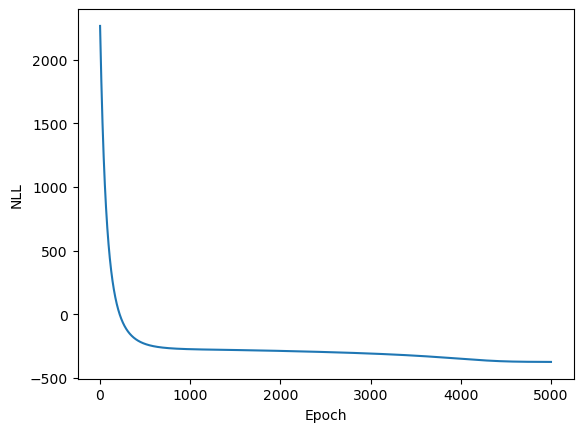

In [5]:
model = NeuralTPP(hidden_dim=32)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
epochs = 5000

with tqdm.tqdm(range(1, epochs), unit="epoch") as tepoch:
    for epoch in tepoch:
        optimizer.zero_grad()
        loss = model.log_likelihood(times, mask)
        loss = -loss.mean()
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        tepoch.set_postfix(NLL=loss.item())

plt.plot(range(1, epochs), losses)
plt.ylabel("NLL")
plt.xlabel("Epoch")
plt.show()